# Simple Kalman Filter Falling Ball Example

This project is going to show how a Kalman filter works by using the example of a falling ball.

From our laws of physics, we know that the trajectory of the ball is: $ x_t = x_{t-1} + v_{t-1} \Delta t + \frac{1}{2} a_{t-1} (\Delta t)^2 $ 

and the velocity of the ball (assuming no drag) is given by: $ v_t = v_{t-1} + a_{t-1} \Delta t $

our state vector will be: $ \vec{X_t} = \begin{pmatrix} x_t \\ v_t \end{pmatrix} $

In [1]:
# installing the library dependencies
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# defining the control variables
g = -9.81        # m/s^2
t_end = 5       # s
n = 20          # number of data points
dt = t_end/n     # time step in seconds
control_variables = [g]
noise_matrix = np.zeros((2,1))

Now we will calculate the predicted state of the matrix, with our matrices as follows: $A = \begin{pmatrix} 1& \Delta T\\0&1\end{pmatrix} $ and $ B = \begin{pmatrix} \frac{1}{2}(\Delta T)^2 \\ 1\end{pmatrix} $

In [3]:
# calculating the predicted state

def calculate_predicted_state(state_vector, control_variable_vector, dt, noise_matrix):
    
    # defining the A matrix
    A = np.matrix([[1, dt], [0, 1]])
    
    #defining the B matrix
    B = np.matrix([[0.5*(dt**2)],[1]])
    
    #calculating the predicted state
    predicted_x = A * state_vector + B * control_variable_vector[0] + noise_matrix
    
    return predicted_x

In [4]:
def calculate_new_covariance_matrix(previous_covariance_matrix, dt ,noise_covariance_matrix=np.zeros((2,1))):
    # defining the A matrix
    A = np.matrix([[1, dt], [0, 1]])
    
    #defining the Q matrix - for now we will set this to 0
    Q = np.zeros((2,2))
    
    #calculating the new P matrix
    p_new = A * previous_covariance_matrix * A.transpose() + Q
    
    #for now, we will just get the diagonal terms from the matrix
    p_new_diag = np.diag(np.diag(p_new))
    
    return p_new_diag

In [5]:
def calculate_kalman_gain(state_covariance_matrix, measurement_noise_covariance_matrix):
    #defining the H matrix
    H = np.identity(2)
    
    # calculating the kalman gain
    kalman_gain_numerator = state_covariance_matrix * H.transpose()
    kalman_gain_denominator = H * state_covariance_matrix * H.transpose() + measurement_noise_covariance_matrix
    
    # based on the assumption that the numerator and denominators are diagonal matrices, we can extract
    # the diagonal elements into a list and divide them and then put back into a matrix
    kalman_numerator_list = np.diag(kalman_gain_numerator)
    kalman_denominator_list = np.diag(kalman_gain_denominator)
    
    #getting the kalman gain matrix
    kalman_gain_matrix = np.matrix(np.diag(np.divide(kalman_numerator_list,kalman_denominator_list)))
    
    return kalman_gain_matrix

In [6]:
def process_next_observation(observation_vector,adjustment_noise= np.zeros((2,1))):
    #defining the C matrix
    C = np.identity(2)
    
    # processing the observation
    y_new = C * observation_vector + adjustment_noise
    
    return y_new

In [7]:
def calculate_updated_state(kalman_gain_matrix,predicted_state_vector,observation_vector):
    # defining the H matrix
    H = np.identity(2)
    
    #calculating the new x vector
    x_updated_vector = predicted_state_vector + kalman_gain_matrix * (observation_vector - predicted_state_vector)
    
    return x_updated_vector

In [8]:
def calculate_updated_process_covariance_matrix(kalman_gain_matrix,process_covariance_matrix):
    #defining the I and H matrices
    I = np.identity(2)
    H = np.identity(2)
    
    # calculating the updated covariance matrix
    p_updated = (I - kalman_gain_matrix * H) * process_covariance_matrix
    
    return p_updated

In [9]:
# plotting the real path of the ball
t = np.linspace(0,t_end,100)
x = 100 + g/2 * t ** 2

In [10]:
# generating the 'observed values of the ball'
t_obs = np.linspace(0,t_end,n)
x_obs = [(100 + g/2 * (t ** 2) + np.random.normal(0,3)) for t in t_obs]
v_obs = [(0 + g * t + np.random.normal(0,3)) for t in t_obs]

In [25]:
#define the initial state variables
x_initial = np.matrix([[140],[3]])
p_initial = np.matrix(np.diag([3,3]))

# set up the current variables
x_current = x_initial
p_current = p_initial

#set up the empty list
x_kalman = [x_initial[0]]
p_kalman1 = [p_initial.item(0,0)]
p_kalman2 = [p_initial.item(1,1)]

for k in range(1,n):
    #calculate the predicted state
    x_predicted = calculate_predicted_state(x_current,control_variables,dt,noise_matrix)

    # calculate the predicted covariance matrix
    p_predicted = calculate_new_covariance_matrix(p_current, dt ,noise_matrix)

    # calculate the Kalman Gain matrix
    kalman_gain_matrix = calculate_kalman_gain(p_predicted, np.diag([0.25,0.25])) 

    # process the newest observation
    observation = np.matrix([[x_obs[k]],[v_obs[k]]])

    processed_observation = process_next_observation(observation,noise_matrix)

    # calculate the updated state
    x_updated = calculate_updated_state(kalman_gain_matrix,x_predicted,processed_observation)

    # calculating the updated process covariance matrix
    p_updated = calculate_updated_process_covariance_matrix(kalman_gain_matrix,p_predicted)

    x_kalman.append(x_updated[0])
    p_kalman1.append(p_updated.item(0,0))
    p_kalman2.append(p_updated.item(1,1))

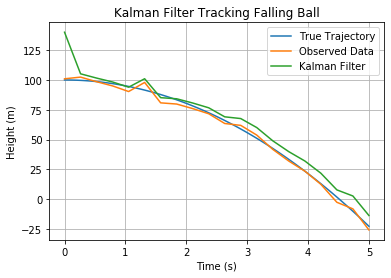

In [26]:
plt.plot(t,x, label='True Trajectory')
plt.plot(t_obs,x_obs,label='Observed Data')
plt.plot(t_obs,np.reshape(x_kalman,(n,)),label='Kalman Filter')
plt.grid(True)
plt.title('Kalman Filter Tracking Falling Ball')
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.legend()

plt.show()

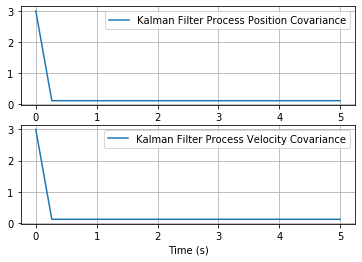

In [16]:
plt.subplot(2,1,1)
plt.plot(t_obs,np.reshape(p_kalman1,(n,)),label='Kalman Filter Process Position Covariance')
plt.grid(True)
plt.xlabel('Time (s)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(t_obs,np.reshape(p_kalman2,(n,)),label='Kalman Filter Process Velocity Covariance')
plt.grid(True)
plt.xlabel('Time (s)')
plt.legend()

plt.show()